# Inferential Statistics

By calculating descriptive statistics and plotting data visualizations, we may see differences in data observed in different conditions. However, before we conclude that there is a real difference, we must first consider the possibility that we are not observing true differences, but instead differences due to chance. We can test this possibility using inferential statistics.

## Simulation: no real effect

First, we'll simulate a case where there are two conditions, but no actual difference between them. For example, say we had an hypothesis, for some reason, that people born on an odd-numbered day had higher IQ than people who were born on an even-numbered day. There is no actual relationship between birthday parity and IQ, so the IQ distribution would be the same for both groups, given a large enough sample size.

*But we still might observe a difference between the mean IQ of the two conditions*. This happens sometimes due to random chance.

First, we'll use NumPy to generate some random data. We have two simulated conditions. In the first condition, our measure `x` has a mean of 3 and a standard deviation of 1.5. In the second condition, `x` also has a mean of 3 and a standard deviation of 1.5. There is no difference between conditions. The probability distributions for the simulated conditions are plotted below, with a little shift so both conditions can be seen.

Text(0.5, 0, 'x')

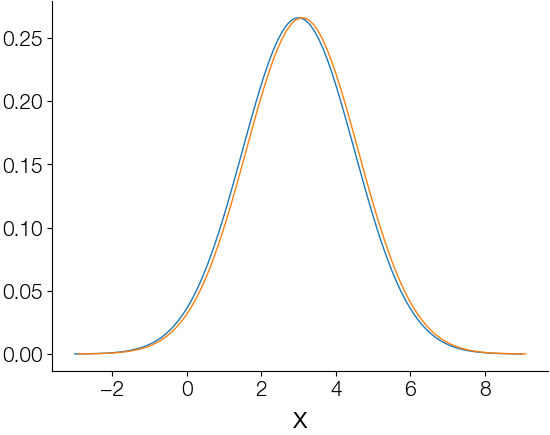

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
mu1 = 3
sigma1 = 1.5
mu2 = 3
sigma2 = 1.5
x_vals = np.linspace(-3, 9, 100)
fig, ax = plt.subplots()
ax.plot(x_vals, stats.norm.pdf(x_vals, mu1, sigma1))
ax.plot(x_vals + .1, stats.norm.pdf(x_vals, mu2, sigma2))
ax.set_xlabel("x")

When we generate samples of `x`, however, we will sometimes end up with a difference in the mean value of `x` in the two samples.

In [2]:
rng = np.random.default_rng(10)
n1 = 25
n2 = 25
x1 = rng.normal(mu1, sigma1, size=n1)
x2 = rng.normal(mu2, sigma2, size=n2)

Here is one case where we've happened to sample two distributions that look a little different. We'll package it up as a DataFrame so we can use Seaborn's `displot` function.

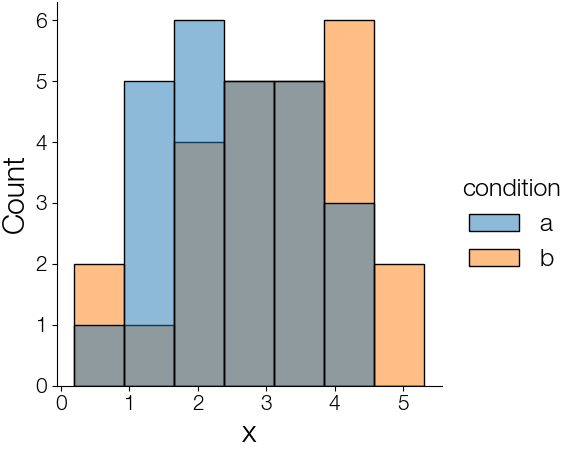

In [3]:
import polars as pl
import seaborn as sns
import pingouin as pg
df = pl.DataFrame(
    {
        "x": np.concat([x1, x2]), 
        "condition": np.repeat(["a", "b"], [n1, n2]), 
        "trial": np.hstack([np.arange(1, n1 + 1), np.arange(1, n2 + 1)]),
    }
)
sns.displot(df, x="x", hue="condition");

The mean value of `x` looks somewhat different in the two conditions, even though they were drawn from the same distribution.

In [4]:
m = df.group_by("condition").agg(pl.col("x").mean()).sort("condition")
m

condition,x
str,f64
"""a""",2.493025
"""b""",3.030984


Sometimes, it may look like there is an effect, even when there really isn't, just due to chance. How can we tell whether an effect is due to a real difference, or just due to random variability?

## Null hypothesis significance testing

There's never really a guarantee that a difference between conditions on some measure is real. However, we can use statistics to minimize the possibility of being led astray by random chance. The most common approach to testing hypotheses using statistics is called *null hypothesis significance testing*, or NHST.

In the NHST approach, we start by considering the possibility that there is no effect; that is, our two conditions do not differ on our measure `x`. Then we examine the data we observed, and calculate the *p-value*. The p-value is the probability of having observed a set of measurements, assuming the *null hypothesis* that there is no difference between conditions.

Let's go back to the simulation example from before. Here are the distributions for the two conditions again.

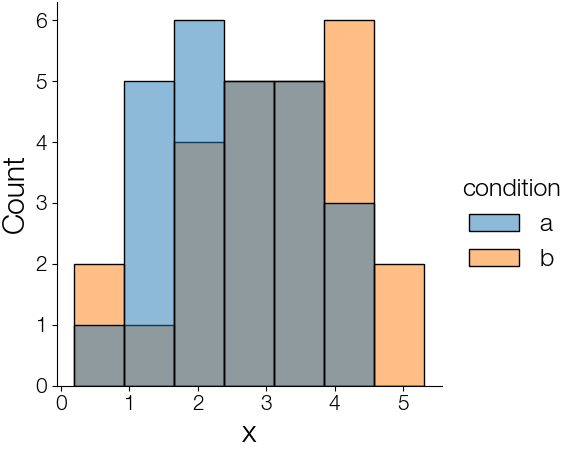

In [5]:
sns.displot(df, x="x", hue="condition");

In our simulation, condition b ended up with a larger value of `x` than condition a.

In [6]:
diff = np.mean(x2) - np.mean(x1)
diff

np.float64(0.5379595626031382)

With some statistical assumptions, it is possible to calculate the probability of observing a difference at least this large, assuming that the null hypothesis is true. We first calculate a *t-statistic*. The t-stat is the difference between the means of the conditions, divided by an estimate of the standard deviation.

In [7]:
s = np.sqrt(np.var(x1, ddof=1) / n1 + np.var(x2, ddof=1) / n2)
t = diff / s
t

np.float64(1.598921122269287)

This statistic follows a *t* distribution. We can compare our t-value to the probability distribution for t-statistics.

Text(0.5, 0, 't')

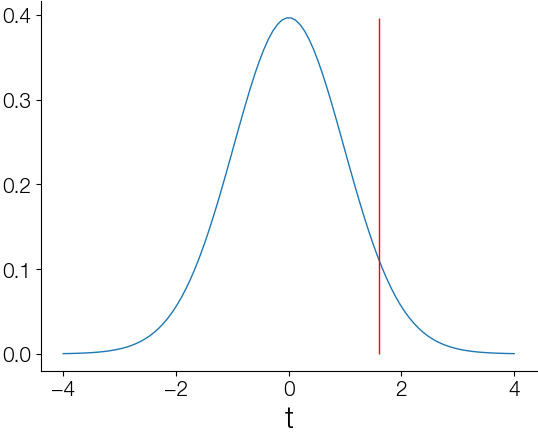

In [ ]:
tx = np.linspace(-4, 4, 100)
ty = stats.t.pdf(tx, n1 + n2 - 2)
fig, ax = plt.subplots()
ax.plot(tx, ty)
ax.vlines(t, 0, np.max(ty), color="r");
ax.set_xlabel("t");

We can use the cumulative distribution function to *t* to calculate the probability of observing a value at least as extreme as our *t*-value. This is known as the p-value.

In [9]:
(1 - stats.t.cdf(t, n1 + n2 - 2)) * 2

np.float64(0.11640075282849605)

The p-value represents the probability of having observed a difference in means as extreme of this, assuming that there is no effect.

This is *not* the probability that our observations are due to chance. Instead, it is the probability of our observations occurring *assuming* that they are due to chance.

When the p-value is small, we may decide to *reject the null hypothesis*. In psychology, the usual standard is that we decide to reject the null hypothesis when $p < 0.05$. This means that, if the null hypothesis is true, we will have a *false positive* (that is, a false rejection of the null hypothesis) less than 5% of the time.

Confused? That's okay! The use of null hypothesis significance testing and p-values is famously counterintuitive. Just remember to be careful when thinking about the meaning of p-values, and look up the definition periodically to remind yourself how it is defined.

We don't have to make t-test calculations by hand, of course. The Pingouin package will quickly run a t-test and provide a table of related statistics.

In [10]:
pg.ttest(x1, x2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.598921,48,two-sided,0.116401,"[-1.21, 0.14]",0.452243,0.798,0.347368


## Pingouin statistical tests

The Pingouin package is designed to make it easier to run various statistical tests, including various kinds of t-tests. There are many different ways to use NHST to test various hypotheses, but we will focus on a few common tests that are used in psychology research.

one-sample t-test
: test whether a distribution has some specific mean

two-sample paired t-test
: test whether two conditions, measured within subjects, have the same mean

one-way repeated-measures ANOVA
: test whether two or more conditions, measured within subjects, have the same mean

two-way repeated-measures ANOVA
: test whether two within-subject factors, each of which may have multiple groups, have the same means

We will use the `study.csv` file to illustrate these examples.

In [11]:
study = (
    pl.read_csv(
        "study.csv", null_values="n/a", schema_overrides={"item_type": pl.String}
    )
    .with_columns(
        pl.col("item_type").replace({"1": "word", "2": "picture"}),
    )
)
study

participant_id,trial_type,item_type,response,response_time
i64,str,str,i64,f64
1,"""target""","""word""",1,1.5
1,"""lure""","""picture""",0,2.3
1,"""target""","""picture""",1,1.7
1,"""target""","""word""",0,2.2
1,"""lure""","""picture""",1,1.8
…,…,…,…,…
3,"""lure""","""picture""",1,2.5
3,"""target""","""picture""",1,1.6
3,"""lure""","""picture""",0,2.8


## One-sample t-test

We can use a one-sample t-test to examine whether a measure is different from some null value. For example, when participants see a word and must choose whether it is "old" or "new", they have a 50% chance of getting it correct. For example, we can use a t-test to test whether targets are responded to correctly more than expected due to chance.

First, we get target trials and calculate the mean response to get accuracy.

In [12]:
m_target = (
    study.filter(pl.col("trial_type") == "target")
    .group_by("participant_id")
    .agg(pl.col("response").mean())
    .sort("participant_id")
)
m_target

participant_id,response
i64,f64
1,0.75
2,0.75
3,1.0


Next, we use a one-sample t-test to test whether the response accuracy is greater than 0.5. The first input give the data for the measure we are interested in, and the second input gives the mean that we would expect due to chance.

In [13]:
pg.ttest(m_target["response"], 0.5)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.0,2,two-sided,0.057191,"[0.47, 1.19]",2.309401,2.358,0.564514


Although accuracy is fairly high (75%, 75%, and 100%, for the three participants), $p > 0.05$, so we conclude that there is not a significant effect here (that is, we do not reject the null hypothesis). That isn't surprising, because three participants is a very small sample size, so even three high-performing participants is not very strong evidence that the overall population of participants performs above chance on average.

## Two-sample paired t-test

In studies with within-subject designs, each participant completes two or more conditions. In this type of design, we can ask whether participants have different behavioral measures on the two conditions.

We'll examine whether response times were different for target and lure trials. We first need to get the data into shape. A pivot table works well to arrange the data so we can access measures from both conditions.

In [14]:
df = (
    study.drop_nulls()
    .pivot("trial_type", index="participant_id", values="response_time", aggregate_function="mean")
)
df

participant_id,target,lure
i64,f64,f64
1,1.75,2.1
2,1.425,2.125
3,1.766667,2.525


To complete a paired t-test, we pass the two samples (target and lure) and indicate that they are `paired`. That is, the target and lure arrays are matched up, so that scores in the same position come from the same participant.

In [15]:
pg.ttest(df["target"], df["lure"], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.727456,2,two-sided,0.04195,"[-1.15, -0.05]",2.78068,2.839,0.693374


We actually get the same result if we first calculate a difference score, and then compare that to zero using a one-sample t-test.

In [16]:
pg.ttest(df["target"] - df["lure"], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.727456,2,two-sided,0.04195,"[-1.15, -0.05]",2.729398,2.839,0.680436


## One-way repeated-measures ANOVA

Analysis of variance (ANOVA) tests can be used to test whether multiple groups have the same means.

If the factor varies within subject, we must use a repeated-measures ANOVA. This works similarly to a paired t-test, but allows for more than two groups.

We can use a repeated-measures ANOVA to test for differences in groups. If there are two groups, usually we will use a t-test, but a repeated-measures ANOVA will give exactly the same p-value. Pingouin is not yet fully compatible with Polars, so we must convert our Polars DataFrame to a Pandas DataFrame to run the `rm_anova` function.

In [17]:
study_df = study.to_pandas()
pg.rm_anova(data=study_df, dv="response_time", within="trial_type", subject="participant_id")

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,trial_type,1,2,22.348837,0.04195,0.743561,1.0


In this example, there were only two trial types, but we can apply the same analysis to cases where there are more than two groups.

## Two-way repeated-measures ANOVA

We can use a two-way ANOVA instead if there are two factors that were are interested in.

For example, say we want to test whether trial type, item type, or some combination of both factors, influence response time. Let's visualize these variables using a bar plot.

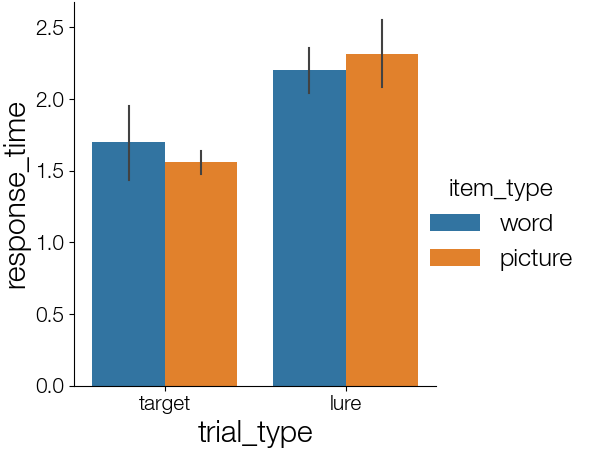

In [18]:
sns.catplot(data=study, x="trial_type", y="response_time", hue="item_type", kind="bar");

We can run an ANOVA to test for the following:

A main effect of trial type. This would indicate that trial type has an effect on response time, regardless of item type.

A main effect of item type. This would indicate that item type has an effect on response time, regardless of trial type.

An interaction. This would indicate that the effect of one variable on response time is dependent on the other variable.

In [19]:
pg.rm_anova(data=study_df, dv="response_time", within=["trial_type", "item_type"], subject="participant_id")

/Users/morton/VS Code/datascipsych/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/morton/VS Code/datascipsych/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,trial_type,1.171875,1,2,1.171875,23.734177,0.039645,0.039645,0.734622,1.0
1,item_type,0.000208,1,2,0.000208,0.007874,0.937378,0.937378,0.000492,1.0
2,trial_type * item_type,0.046875,1,2,0.046875,3.571429,0.199359,0.199359,0.099690,1.0


Note that this time, we have three p-values instead of one! There are three tests, which correspond to the two main effects and the interaction.

## Summary

We used a simulation to demonstrate how apparent differences between conditions can sometimes occur due to chance. We can use null hypothesis significance testing (NHST) to reduce false positives where we conclude that there is a difference, even when there isn't one. To do this, we use run a statistical test and reject the null hypothesis if $p < 0.05$.

There are many different types of hypothesis tests, depending on how many conditions we want to compare and whether the conditions are within- or between-subject. Here, we focused on within-subject effects, but there are also tests for comparing groups of subjects that completed different conditions. See the [Pingouin documentation](https://pingouin-stats.org/build/html/api.html) for details about more inferential statistics.